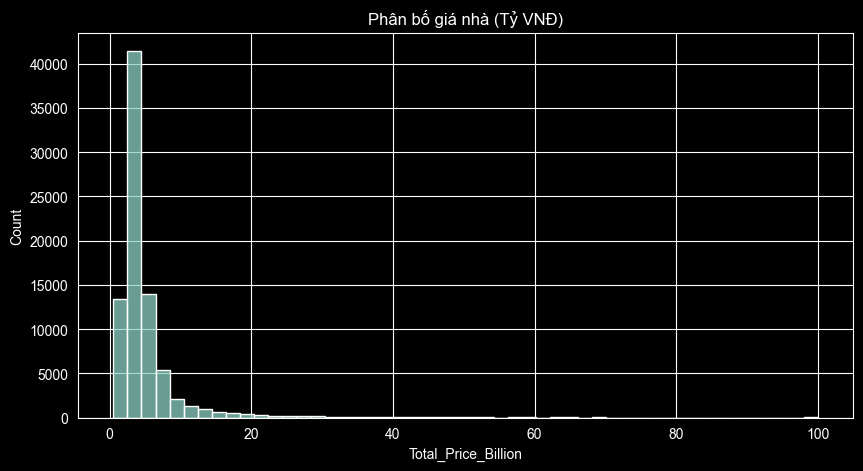

Đã lưu file sạch thành công!


In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/raw/VN_housing_dataset.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df.columns = [
    'Date', 'Address', 'District', 'Ward', 'House_type', 'Legal', 'Floors', 'Bedrooms', 'Area', 'Length', 'Width', 'Price_per_m2'
]

# Hàm làm sạch số (loại bỏ chữ, đổi dấu phẩy thành chấm)
def extract_number(value):
    if pd.isna(value): return np.nan
    # Chuyển về chuỗi thường
    text = str(value).lower()
    # Nếu có dấu phẩy (86,96) thay bằng chấm (86.96)
    text = text.replace(',', '.')
    # Tìm số (bao gồm cả số thập phân)
    match = re.search(r"[-+]?\d*\.\d+|\d+", text)
    if match:
        return float(match.group())
    return np.nan

# Áp dụng cho các cột số
cols_to_clean = ['Area', 'Length', 'Width', 'Price_per_m2', 'Bedrooms', 'Floors']
for col in cols_to_clean:
    df[col] = df[col].apply(extract_number)

# Tính TỔNG GIÁ TRỊ CĂN NHÀ (Đây là cột quan trọng nhất để dự đoán)
# Công thức: Giá/m2 * Diện tích = Tổng giá (đơn vị: Triệu VNĐ)
df['Total_Price_Billion'] = (df['Price_per_m2'] * df['Area']) / 1000
# (Chia 1000 để đổi từ Triệu sang Tỷ cho số nhỏ dễ nhìn)

# Xử lý cột Quận/Huyện (Bỏ chữ 'Quận', 'Phường')
df['District'] = df['District'].str.replace('Quận', '').str.strip()
df['Ward'] = df['Ward'].str.replace('Phường', '').str.replace('Xã', '').str.strip()

# Xử lý thiếu (Missing Values)
# Xóa dòng nếu thiếu Diện tích hoặc Giá (vì không train được)
df = df.dropna(subset=['Area', 'Total_Price_Billion'])

# Cột Pháp lý: Điền 'Dang_cap_nhat'
df['Legal'] = df['Legal'].fillna('Dang_cap_nhat')

# Cột Số tầng, Phòng ngủ: Điền bằng trung vị (Median)
df['Floors'] = df['Floors'].fillna(df['Floors'].median())
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].median())

# Xóa cột Dài, Rộng (vì thiếu quá nhiều)
df = df.drop(columns=['Length', 'Width'])

# Lọc theo Diện tích
# Chỉ lấy nhà từ 10m2 đến 500m2
df = df[(df['Area'] >= 10) & (df['Area'] <= 500)]

# Lọc theo Giá
# Chỉ lấy nhà giá từ 500 Triệu (0.5 tỷ) đến 100 Tỷ
df = df[(df['Total_Price_Billion'] >= 0.5) & (df['Total_Price_Billion'] <= 100)]

# Lưu file sạch
df.to_csv('../data/processed/clean_vn_housing.csv', index=False)
